In [605]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.feature_extraction.text import TfidfVectorizer as tfidf
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix


In [581]:
tech = pd.read_csv("/Users/jennayang/Documents/Medium Project Data/medium-tech-data.csv")
money = pd.read_csv("/Users/jennayang/Documents/Medium Project Data/Medium_Money_Data_final.csv", index_col = 0) 
sports = pd.read_csv("/Users/jennayang/Documents/Medium Project Data/medium-sports-data.csv", index_col = 0) 
politics = pd.read_csv("/Users/jennayang/Documents/Medium Project Data/Politics_data_full.csv", index_col = 0) 

In [582]:
#there was a bug with the webscraping: people with 2020 claps have the wrong number of claps. 
#checked via website, having differing number of claps
politics = politics[politics.claps != 2020]

#get ratio of clap to followers, put as a new feature
clap_ratio = politics.claps / politics.followers

#get number of followers:
followers = politics.followers

#put the clap ratio as a new feature
politics["clap_ratio"] = clap_ratio



In [583]:
#cleaning the data - removing nulls and empty vals
tech = tech[pd.notnull(tech['text'])]
tech.reset_index(inplace = True)

sports = sports[pd.notnull(sports['text'])]
sports.reset_index(inplace = True)

politics = politics[pd.notnull(politics['text'])]
politics.reset_index(inplace = True)

money = money[pd.notnull(money['text'])] 
money.reset_index(inplace = True)

politics = politics[~(politics.text == '[]')]
money = money[~(money.text == '[]')]
sports = sports[~(sports.text == '[]')]
tech = tech[~(tech.text == '[]')]

#shuffle and randomly select 2000 entries (downsampling tech and politics) (money keep at 1600) (sports keep at 2500)
t = tech.sample(2000, replace= False)[["text"]].reset_index(drop=True)
s = sports.sample(len(sports), replace= False)[["text"]].reset_index(drop=True)
p = politics.sample(2000, replace= False)[["text"]].reset_index(drop=True)
m = money.sample(len(money), replace= False)[["text"]].reset_index(drop=True)

In [584]:
#Breaking our data up into training and test sets (80/20 split)
pd.options.mode.chained_assignment = None #surpress warning

#first, we need to add the labels
t["label"] = [0] * len(t)
s["label"] = [1] * len(s)
p["label"] = [2] * len(p)
m["label"] = [3] * len(m)

#store index of 80/20 split
ind_t = int(len(t) * 0.8)
ind_s = int(len(s) * 0.8)
ind_p = int(len(p) * 0.8)
ind_m = int(len(m) * 0.8)

#making the training set and test sets
t_train = t.iloc[:ind_t] 
s_train = s.iloc[:ind_s] 
p_train = p.iloc[:ind_p] 
m_train = m.iloc[:ind_m] 

t_test = t.iloc[ind_t:] 
s_test = s.iloc[ind_s:] 
p_test = p.iloc[ind_p:] 
m_test = m.iloc[ind_m:] 

In [585]:
#combining all the topics into train and test
ts = pd.concat([t_train, s_train], axis = 0)
pm = pd.concat([p_train, m_train], axis = 0)
train = pd.concat([ts, pm], axis = 0)

ts_test = pd.concat([t_test, s_test], axis = 0)
pm_test = pd.concat([p_test, m_test], axis = 0)
test = pd.concat([ts_test, pm_test], axis = 0)

In [586]:
#shuffling
train = train.sample(frac = 1, replace = False).reset_index(drop=True)
test = test.sample(frac = 1, replace = False).reset_index(drop=True)

#get X and Y data from the sets
X_train = train.text
Y_train = train.label

X_test = test.text
Y_test = test.label


In [587]:
train.head()

,text,label
0,"When Jim Bouton died on July 10th, attention f...",1
1,"['[Saudi Arabia isn’t a very lovable country, ...",2
2,Look. We all do it. Everyone tries to concoct ...,1
3,['[You’ve recently graduated (or maybe you’ve ...,3
4,This blog post has been published in the conte...,0


In [588]:
#create the vector
#focus on max_features as well
vector = tfidf(stop_words = "english", strip_accents = 'ascii', max_features = 50)

#fit the data
vector.fit(X_train)

#look at the vectorizer
print(vector.get_feature_names())


['000', 'american', 'best', 'better', 'day', 'did', 'does', 'dont', 'financial', 'game', 'going', 'good', 'government', 'home', 'im', 'income', 'just', 'know', 'life', 'like', 'long', 'make', 'market', 'money', 'need', 'new', 'pay', 'people', 'point', 'political', 'president', 'really', 'right', 'said', 'say', 'states', 'team', 'thats', 'things', 'think', 'time', 'trump', 'use', 'want', 'way', 'work', 'world', 'year', 'years', 'youre']


In [633]:
#transforming the data, manipulating it based on the weights we 
#determined before by fitting our data 
train_transformed = vector.fit_transform(X_train)
test_transformed = vector.transform(X_test)

#splitting
train_test_split(train_transformed, Y_train)[0], train_test_split(train_transformed, Y_train)[1]

(<4902x69155 sparse matrix of type '<class 'numpy.float64'>'
 	with 1135020 stored elements in Compressed Sparse Row format>,
 <1635x69155 sparse matrix of type '<class 'numpy.float64'>'
 	with 373560 stored elements in Compressed Sparse Row format>)

In [598]:
#create the KNN model
knearest = knn(n_neighbors = 37)

#fit the model with training data
knearest.fit(train_transformed, Y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=37, p=2,
                     weights='uniform')

In [599]:
knearest.score(test_transformed, Y_test)

0.746177370030581

# Hyperparameter Tuning and Cross Validation

In [ ]:
#Cross Validation for k

# creating odd list of k for KNN (to prevent ties)
neighbors = list(range(1, 50, 2))
# empty list that will hold cv scores
cv_scores = []


# perform 10-fold cross validation
for k in neighbors:
    knearest = knn(n_neighbors = k)
    scores = cross_val_score(knearest, train_transformed, Y_train, cv = 10, scoring='accuracy')
    cv_scores.append(scores.mean())
    
# plot of accuracies for different k 
plt.plot(neighbors, cv_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

In [592]:
#Trying different k values
knn_scores = []

for i in range(1, 50, 2):
    knearest = knn(n_neighbors = i)
    knearest.fit(train_transformed, Y_train)
    
    knn_scores.append(knearest.score(test_transformed, Y_test))

In [595]:
knn_scores

[0.7137614678899082,
 0.7223241590214067,
 0.7345565749235474,
 0.6978593272171254,
 0.6984709480122324,
 0.7064220183486238,
 0.7033639143730887,
 0.708868501529052,
 0.7351681957186544,
 0.7363914373088685,
 0.7388379204892966,
 0.7363914373088685,
 0.7425076452599388,
 0.7388379204892966,
 0.7437308868501529,
 0.7394495412844037,
 0.7370030581039755,
 0.7431192660550459,
 0.746177370030581,
 0.7388379204892966,
 0.7376146788990826,
 0.7382262996941896,
 0.7412844036697248,
 0.7406727828746177,
 0.7425076452599388]

In [597]:
best_k = (knn_scores.index(max(knn_scores)) + 1) * 2 - 1
best_k

37

In [600]:
#final vector written here (no max number of features)
vector = tfidf(stop_words = "english", strip_accents = 'ascii', max_features = None)

#fit the tfidf on all the train data:
train_final = vector.fit_transform(train["text"])

#the final transformation and fitting before using the test data:
test_final = vector.transform(X_test)

In [601]:
#fit model on FULL train data
dt.fit(train_final, train["label"])

#score it on the test data
final_score = dt.score(test_final, Y_test)

#the final score
final_score

0.8397553516819571

In [632]:
#get predictions from the decision tree
predictions = dt.predict(test_final)

predictions

array([3, 1, 1, ..., 1, 0, 2])

In [620]:
#creating a function to normalize the confusion matrix:
#used sklearn docs for the labels and axis!

def normed_cm(real, predictions):
    """Majority of code from:
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    to make a confusion matrix, given real labels and predicted labels"""
    
    #get the confusion matrix:
    cm = confusion_matrix(real, predictions)
    
    #normalized
    normed = []
    for row in np.arange(4):
         normed.append(cm[row]/sum(cm[row]))
    cm = np.array(normed)

    #axis and labels:
    fig, ax = plt.subplots()
    classes = ["tech", "sports", "politics", "money"]
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               # ... and label them with the respective list entries
               xticklabels=classes, yticklabels=classes,
               title="Comparing Class Classification",
               ylabel='True label',
               xlabel='Predicted label');
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.tight_layout()
    return ax

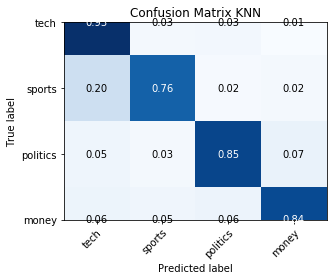

In [627]:
normed_cm(test["label"],predictions)
plt.title("Confusion Matrix KNN");


In [607]:
#get the confusion matrix:
cm = confusion_matrix(test["label"], predictions)
cm

array([[373,  11,  13,   3],
       [103, 382,   8,  12],
       [ 20,  10, 342,  28],
       [ 19,  15,  20, 276]])

In [613]:
normed = []
for row in np.arange(4):
     normed.append(cm[row]/sum(cm[row]))
        
cm = np.array(normed)

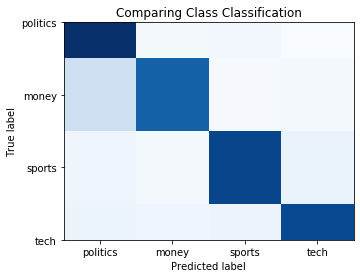

In [616]:
fig, ax = plt.subplots()
classes = ["politics", "money", "sports", "tech"]
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title="Comparing Class Classification",
           ylabel='True label',
           xlabel='Predicted label');

# Analysis

In [ ]:
Clusters?
Suprevised and Unsuprevised - clarify
confusion matrix?